### Библиотеки

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import logging
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import warnings
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
import itertools
from xgboost import XGBClassifier
from tabulate import tabulate

In [2]:
logging.basicConfig(filename='anomalous_behavior.log', level=logging.INFO, format='%(asctime)s - %(message)s')

In [3]:
train_data = pd.read_csv('./csv/Train_data.csv')

In [4]:
test_data = pd.read_csv('./csv/Test_data.csv')

In [5]:
train_data.head()

,длительность,тип_протокола,сервис,состояние_соединения,исходящие_байты,принятые_байты,локальная_сеть,неправильный_фрагмент,срочный,активность,...,количество_сервисов_на_хосте_назначения,частота_одинаковых_сервисов_на_хосте_назначения,частота_различных_сервисов_на_хосте_назначения,частота_одинаковых_исходных_портов_на_хосте_назначения,частота_различных_хостов_обслуживающих_различные_сервисы_на_хосте_назначения,частота_ошибок_сервера_на_хосте_назначения,частота_ошибок_сервера_сервиса_на_хосте_назначения,частота_ошибок_получателя_на_хосте_назначения,частота_ошибок_получателя_сервиса_на_хосте_назначения,класс
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,нормальный
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,нормальный
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,аномальный
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,нормальный
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,нормальный


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                                                                        Non-Null Count  Dtype  
---  ------                                                                        --------------  -----  
 0   длительность                                                                  25192 non-null  int64  
 1   тип_протокола                                                                 25192 non-null  object 
 2   сервис                                                                        25192 non-null  object 
 3   состояние_соединения                                                          25192 non-null  object 
 4   исходящие_байты                                                               25192 non-null  int64  
 5   принятые_байты                                                                25192 non-null  int64  
 6   локальная_сеть                

In [7]:
train_data.describe()

,длительность,исходящие_байты,принятые_байты,локальная_сеть,неправильный_фрагмент,срочный,активность,количество_неудачных_попыток_входа,авторизован,количество_скомпрометированных,...,количество_хостов_назначения,количество_сервисов_на_хосте_назначения,частота_одинаковых_сервисов_на_хосте_назначения,частота_различных_сервисов_на_хосте_назначения,частота_одинаковых_исходных_портов_на_хосте_назначения,частота_различных_хостов_обслуживающих_различные_сервисы_на_хосте_назначения,частота_ошибок_сервера_на_хосте_назначения,частота_ошибок_сервера_сервиса_на_хосте_назначения,частота_ошибок_получателя_на_хосте_назначения,частота_ошибок_получателя_сервиса_на_хосте_назначения
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,...,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,...,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
train_data.describe(include='object')

,тип_протокола,сервис,состояние_соединения,класс
count,25192,25192,25192,25192
unique,3,66,11,2
top,tcp,http,SF,нормальный
freq,20526,8003,14973,13449


In [9]:
train_data.shape

(25192, 42)

In [10]:
train_data.isnull().sum()

длительность                                                                    0
тип_протокола                                                                   0
сервис                                                                          0
состояние_соединения                                                            0
исходящие_байты                                                                 0
принятые_байты                                                                  0
локальная_сеть                                                                  0
неправильный_фрагмент                                                           0
срочный                                                                         0
активность                                                                      0
количество_неудачных_попыток_входа                                              0
авторизован                                                                     0
количество_скомп

In [11]:
total = train_data.shape[0]
missing_columns = [col for col in train_data.columns if train_data[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = train_data[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")

In [12]:
print(f"Количество повторяющихся строк: {train_data.duplicated().sum()}")

Количество повторяющихся строк: 0


<Axes: xlabel='класс', ylabel='count'>

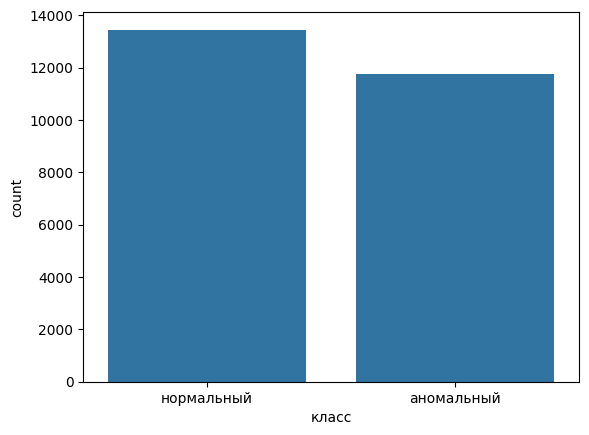

In [13]:
sns.countplot(x=train_data['класс'])

In [14]:
print('Распределение классов. Обучающий набор:')
print(train_data['класс'].value_counts())

Распределение классов. Обучающий набор:
класс
нормальный    13449
аномальный    11743
Name: count, dtype: int64


In [15]:
def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            label_encoder = LabelEncoder()
            df[col] = label_encoder.fit_transform(df[col])

le(train_data)
le(test_data)

In [16]:
train_data.drop(['количество_исходящих_команд'], axis=1, inplace=True)
test_data.drop(['количество_исходящих_команд'], axis=1, inplace=True)

In [17]:
train_data.head()

,длительность,тип_протокола,сервис,состояние_соединения,исходящие_байты,принятые_байты,локальная_сеть,неправильный_фрагмент,срочный,активность,...,количество_сервисов_на_хосте_назначения,частота_одинаковых_сервисов_на_хосте_назначения,частота_различных_сервисов_на_хосте_назначения,частота_одинаковых_исходных_портов_на_хосте_назначения,частота_различных_хостов_обслуживающих_различные_сервисы_на_хосте_назначения,частота_ошибок_сервера_на_хосте_назначения,частота_ошибок_сервера_сервиса_на_хосте_назначения,частота_ошибок_получателя_на_хосте_назначения,частота_ошибок_получателя_сервиса_на_хосте_назначения,класс
0,0,1,19,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,2,41,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,1,46,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,1,22,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,1,22,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


### Выбор функции

In [18]:
X_train = train_data.drop(['класс'], axis=1)
Y_train = train_data['класс']

In [19]:
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['тип_протокола',
 'сервис',
 'состояние_соединения',
 'исходящие_байты',
 'принятые_байты',
 'количество',
 'частота_одинаковых_сервисов',
 'частота_различных_сервисов',
 'количество_сервисов_на_хосте_назначения',
 'частота_одинаковых_сервисов_на_хосте_назначения']

In [20]:
X_train = X_train[selected_features]

### Разделение и масштабирование данных

In [21]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
test_data = scale.fit_transform(test_data)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

In [23]:
x_train.shape

(17634, 10)

In [24]:
x_test.shape

(7558, 10)

In [25]:
y_train.shape

(17634,)

In [26]:
y_test.shape

(7558,)

In [27]:
rfc.fit(x_train, y_train)

RandomForestClassifier()

In [28]:
y_pred = rfc.predict(x_test)

In [29]:
for i in range(len(y_test)):
    if y_pred[i] == 1:
        logging.info(f"Аномальное поведение обнаружено в индексе {i}: {x_test[i]}")

In [30]:
rfc_score = rfc.score(x_test, y_test)
print(f"Точность случайного леса: {rfc_score}")

Точность случайного леса: 0.9965599364911352


## Logistic Regression

In [31]:
import time

In [32]:
from sklearn.linear_model import LogisticRegression

clfl = LogisticRegression(max_iter = 1200000)
start_time = time.time()
clfl.fit(x_train, y_train.values.ravel())
end_time = time.time()
print("Время обучения: ", end_time-start_time)

Время обучения:  0.015013456344604492


In [33]:
start_time = time.time()
y_test_pred = clfl.predict(x_train)
end_time = time.time()
print("Время тестирования: ", end_time-start_time)

Время тестирования:  0.001001596450805664


In [34]:
lg_model = LogisticRegression(random_state = 42)
lg_model.fit(x_train, y_train)

LogisticRegression(random_state=42)

In [35]:
lg_train, lg_test = lg_model.score(x_train , y_train), lg_model.score(x_test , y_test)

print(f"Оценка обучения: {lg_train}")
print(f"Оценка теста: {lg_test}")

Оценка обучения: 0.9288873766587274
Оценка теста: 0.9233924318602805


In [36]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [37]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

c:\Users\frenzy\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## KNN

In [38]:
def objective(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [39]:
study_KNN = optuna.create_study(direction="maximize")
study_KNN.optimize(objective, n_trials=1)
print(study_KNN.best_trial)

FrozenTrial(number=0, state=1, values=[0.9821381317808944], datetime_start=datetime.datetime(2024, 6, 8, 21, 16, 44, 11411), datetime_complete=datetime.datetime(2024, 6, 8, 21, 16, 44, 569911), params={'KNN_n_neighbors': 7}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'KNN_n_neighbors': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=0, value=None)


In [40]:
KNN_model = KNeighborsClassifier(n_neighbors=study_KNN.best_trial.params['KNN_n_neighbors'])
KNN_model.fit(x_train, y_train)

KNN_train, KNN_test = KNN_model.score(x_train, y_train), KNN_model.score(x_test, y_test)

print(f"Оценка обучения: {KNN_train}")
print(f"Оценка теста: {KNN_test}")

Оценка обучения: 0.9849155041397301
Оценка теста: 0.9821381317808944


## Decision Tree

In [41]:
from sklearn.tree import DecisionTreeClassifier

clfd = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
start_time = time.time()
clfd.fit(x_train, y_train.values.ravel())
end_time = time.time()
print("Время обучения: ", end_time-start_time)

Время обучения:  0.01701521873474121


In [42]:
start_time = time.time()
y_test_pred = clfd.predict(x_train)
end_time = time.time()
print("Время тестирования: ", end_time-start_time)

Время тестирования:  0.0020024776458740234


In [43]:
def objective(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 10, log=False)
    classifier_obj = DecisionTreeClassifier(max_features = dt_max_features, max_depth = dt_max_depth)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [44]:
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective, n_trials=30)
print(study_dt.best_trial)

FrozenTrial(number=1, state=1, values=[0.9964276263561789], datetime_start=datetime.datetime(2024, 6, 8, 21, 16, 46, 388739), datetime_complete=datetime.datetime(2024, 6, 8, 21, 16, 46, 414762), params={'dt_max_depth': 22, 'dt_max_features': 9}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=10, log=False, low=2, step=1)}, trial_id=1, value=None)


In [45]:
dt = DecisionTreeClassifier(max_features = study_dt.best_trial.params['dt_max_features'], max_depth = study_dt.best_trial.params['dt_max_depth'])
dt.fit(x_train, y_train)

dt_train, dt_test = dt.score(x_train, y_train), dt.score(x_test, y_test)

print(f"Оценка обучения: {dt_train}")
print(f"Оценка теста: {dt_test}")

Оценка обучения: 1.0
Оценка теста: 0.9944429743318338


In [46]:
data = [["KNN", KNN_train, KNN_test], 
        ["LogisticRegression", lg_train, lg_test],
        ["Decision Tree", dt_train, dt_test]]

col_names = ["Модель", "Оценка обучения", "Оценка теста"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒════════════════════╤═══════════════════╤════════════════╕
│ Модель             │   Оценка обучения │   Оценка теста │
╞════════════════════╪═══════════════════╪════════════════╡
│ KNN                │          0.984916 │       0.982138 │
├────────────────────┼───────────────────┼────────────────┤
│ LogisticRegression │          0.928887 │       0.923392 │
├────────────────────┼───────────────────┼────────────────┤
│ Decision Tree      │          1        │       0.994443 │
╘════════════════════╧═══════════════════╧════════════════╛


In [47]:
SEED = 42
dtc = DecisionTreeClassifier()
knn = KNeighborsClassifier()
lr = LogisticRegression()

In [48]:
from sklearn.model_selection import cross_val_score
models = {}
models['KNeighborsClassifier']= knn
models['LogisticRegression']= lr
models['DecisionTreeClassifier']= dtc

In [49]:
scores = {}
for name in models:
    scores[name]={}
    for scorer in ['precision','recall']:
        scores[name][scorer] = cross_val_score(models[name], x_train, y_train, cv=10, scoring=scorer)

In [50]:
def line(name):
    return '*'*(25-len(name)//2)

for name in models:
    print(line(name), name, 'Проверка модели', line(name))

    for scorer in ['precision','recall']:
        mean = round(np.mean(scores[name][scorer])*100,2)
        stdev = round(np.std(scores[name][scorer])*100,2)
        print ("Среднее значение {}:".format(scorer),"\n", mean,"%", "+-",stdev)
        print()

*************** KNeighborsClassifier Проверка модели ***************
Среднее значение precision: 
 98.45 % +- 0.48

Среднее значение recall: 
 98.24 % +- 0.54

**************** LogisticRegression Проверка модели ****************
Среднее значение precision: 
 91.36 % +- 0.56

Среднее значение recall: 
 95.72 % +- 0.69

************** DecisionTreeClassifier Проверка модели **************
Среднее значение precision: 
 99.56 % +- 0.2

Среднее значение recall: 
 99.54 % +- 0.18



C:\Users\frenzy\AppData\Local\Temp\ipykernel_9620\4244160894.py:4: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  scores=pd.DataFrame(scores).swapaxes("index", "columns")*100


<Axes: >

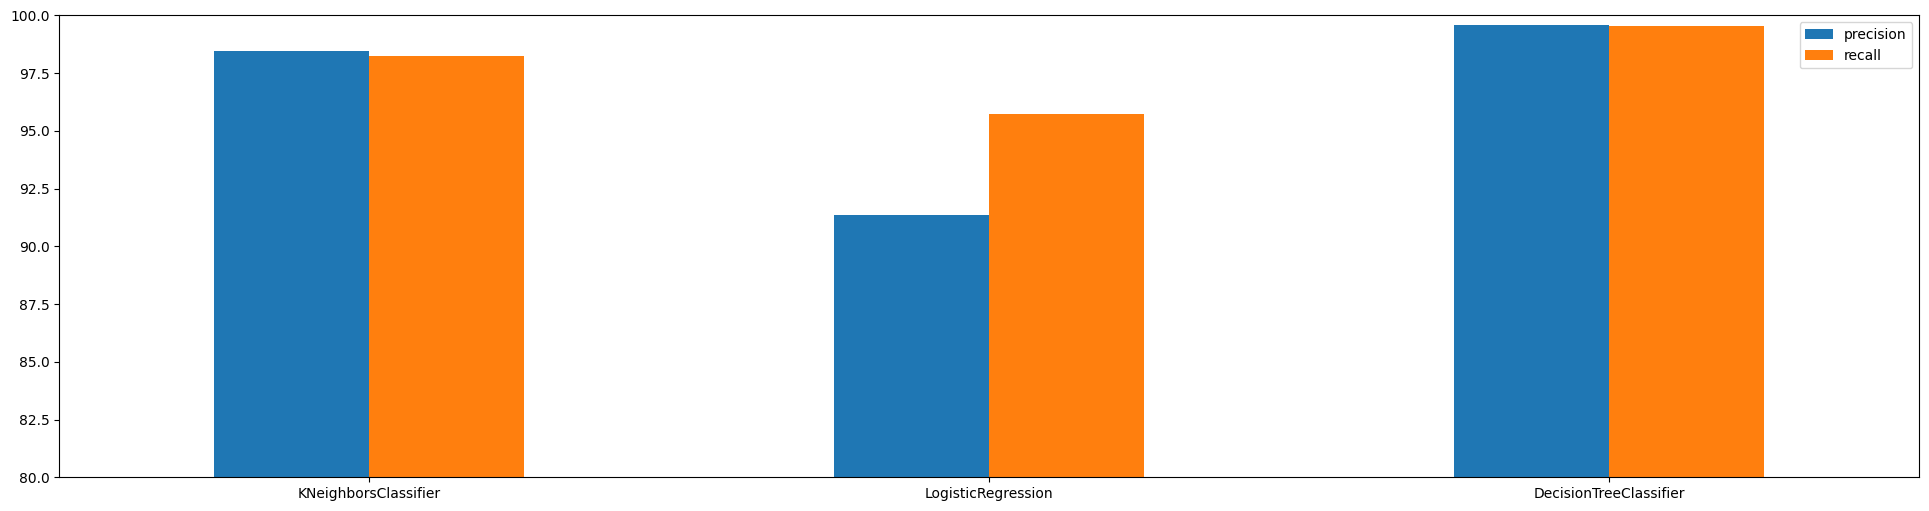

In [51]:
for name in models:
    for scorer in ['precision','recall']:
        scores[name][scorer] = scores[name][scorer].mean()
scores=pd.DataFrame(scores).swapaxes("index", "columns")*100
scores.plot(kind = "bar", ylim=[80,100], figsize=(24,6), rot=0)

In [52]:
models = {}
models['KNeighborsClassifier']= knn
models['LogisticRegression']= lr
models['DecisionTreeClassifier']= dtc

In [53]:
preds={}
for name in models:
    models[name].fit(x_train, y_train)
    preds[name] = models[name].predict(x_test)
print("Прогнозы завершены.")

Прогнозы завершены.


In [54]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
def line(name,sym="*"):
    return sym*(25-len(name)//2)
target_names=["нормальный","аномальный"]
for name in models:
    print(line(name), name, 'Тестирование модели', line(name))
    print(confusion_matrix(y_test, preds[name]))
    print(line(name,'-'))
    print(classification_report(y_test, preds[name], target_names=target_names))

*************** KNeighborsClassifier Тестирование модели ***************
[[3435   63]
 [  65 3995]]
---------------
              precision    recall  f1-score   support

  нормальный       0.98      0.98      0.98      3498
  аномальный       0.98      0.98      0.98      4060

    accuracy                           0.98      7558
   macro avg       0.98      0.98      0.98      7558
weighted avg       0.98      0.98      0.98      7558

**************** LogisticRegression Тестирование модели ****************
[[3129  369]
 [ 210 3850]]
----------------
              precision    recall  f1-score   support

  нормальный       0.94      0.89      0.92      3498
  аномальный       0.91      0.95      0.93      4060

    accuracy                           0.92      7558
   macro avg       0.92      0.92      0.92      7558
weighted avg       0.92      0.92      0.92      7558

************** DecisionTreeClassifier Тестирование модели **************
[[3484   14]
 [  26 4034]]
-------------

<Axes: >

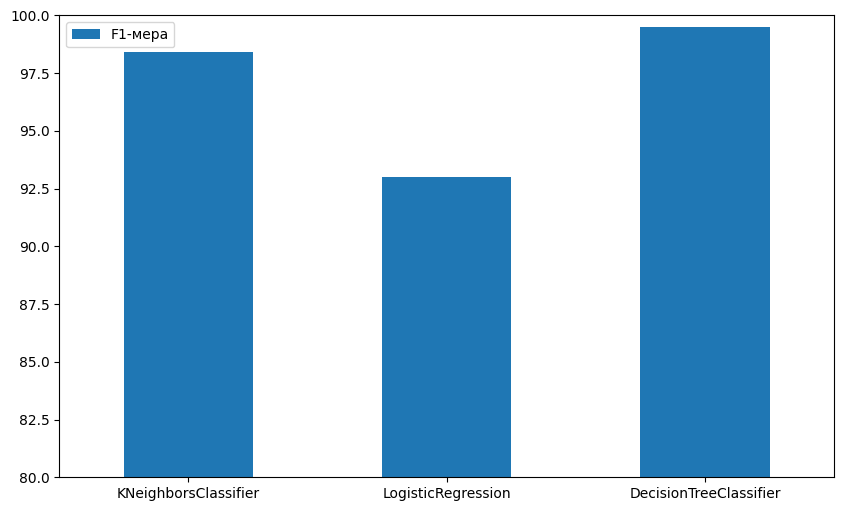

In [55]:
f1s = {}
for name in models:
    f1s[name]=f1_score(y_test, preds[name])
f1s=pd.DataFrame(f1s.values(),index=f1s.keys(),columns=["F1-мера"])*100
f1s.plot(kind = "bar", ylim=[80,100], figsize=(10,6), rot=0)